In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.optimizers import Adam

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from src.model_unet import build_unet
from src.metrics import dice_loss, dice_coef, iou
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D,Input
from tensorflow.keras.models import Model
from keras.models import Model
from src.model2_DeeplabV3 import DeepLabV3Plus
from src.model3_MultiResUNET import build_multiresunet
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import epsilon


In [3]:
H = 128
W = 128


In [4]:
def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

In [6]:
def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

In [7]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x/255.0
    x = x.astype(np.float32)
    return x

In [8]:

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x/255.0
   # x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x


In [9]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

In [10]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [11]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

In [12]:
""" Directory for storing files """
create_dir("files")

In [13]:


""" Hyperparameters """
batch_size = 6
lr = 1e-3
num_epochs = 60
model_path = os.path.join(r"/files", "model.h5")
csv_path = os.path.join(r"files", "data.csv")
    

In [14]:
""" Dataset """
dataset_path = os.path.join("data")
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)


Train: 2156 - 2156
Valid: 376 - 376


In [15]:
# Define a combined loss function of Binary Cross-Entropy and Dice Loss
def combined_loss(y_true, y_pred):
    bce_loss = binary_crossentropy(y_true, y_pred)
    
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    dice_loss = (2.0 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    
    return bce_loss - tf.math.log(dice_loss + epsilon())

# Compile the model with the combined loss function and an optimizer
#model.compile(optimizer='adam', loss=combined_loss)


In [16]:
""" Model """
model = DeepLabV3Plus((H, W, 3))
metrics = ['accuracy',dice_coef, iou, Recall(), Precision(),]
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [17]:
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=9, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
]

In [18]:
history=model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
        shuffle=False
    )

Epoch 1/60
360/360 [==============================] - ETA: 0s - loss: 0.5012 - accuracy: 0.8944 - dice_coef: 0.4994 - iou: 0.3483 - recall: 0.5175 - precision: 0.4962
Epoch 1: val_loss improved from inf to 0.99644, saving model to /files\model.h5
360/360 [==============================] - 50s 107ms/step - loss: 0.5012 - accuracy: 0.8944 - dice_coef: 0.4994 - iou: 0.3483 - recall: 0.5175 - precision: 0.4962 - val_loss: 0.9964 - val_accuracy: 0.9231 - val_dice_coef: 0.0035 - val_iou: 0.0018 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 2/60
359/360 [============================>.] - ETA: 0s - loss: 0.4000 - accuracy: 0.9209 - dice_coef: 0.6000 - iou: 0.4457 - recall: 0.5375 - precision: 0.6630
Epoch 2: val_loss improved from 0.99644 to 0.71630, saving model to /files\model.h5
360/360 [==============================] - 28s 78ms/step - loss: 0.3998 - accuracy: 0.9210 - dice_coef: 0.6007 - iou: 0.4466 - recall: 0.5377 - precision: 0.6632 - val_loss: 0.7163 - val_ac

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib

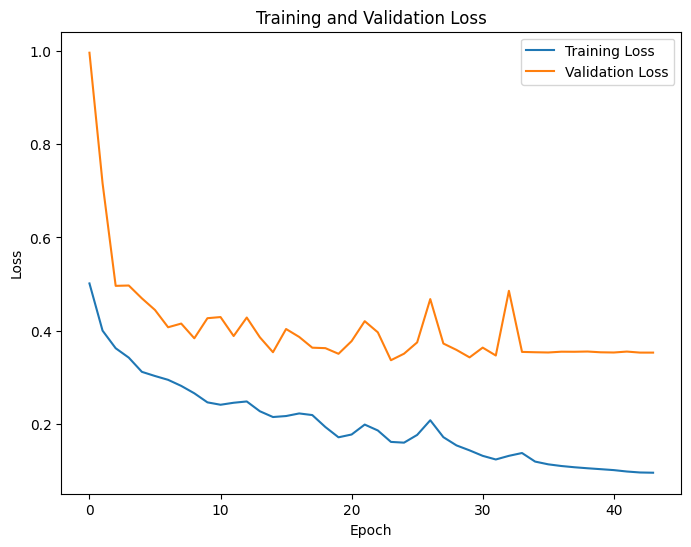

In [20]:
# Plot the training and validation loss vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

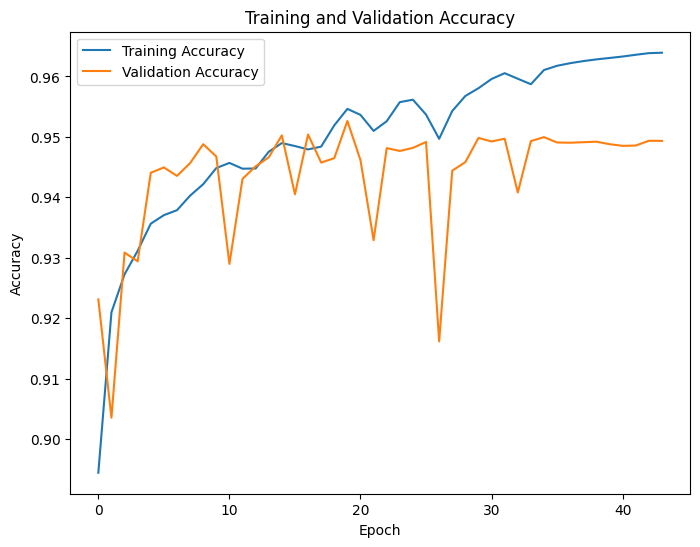

In [21]:
# Plot the training and validation accuracy vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

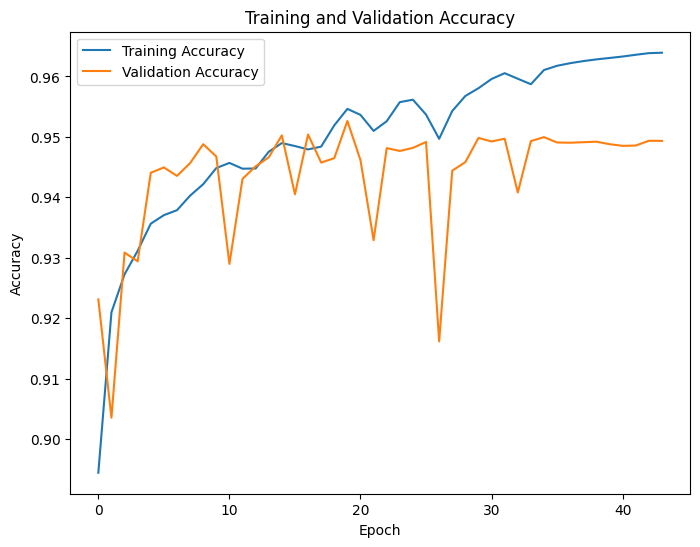

In [22]:
# Plot the training and validation accuracy vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()